In [4]:
# Notes:
# матрица симметричная, не забывать, что может быть двойное включение
# loss function modifyable
# extract_good_regions - может быть другая
# квадраты, которые мы не выбрали для validation set'а

# Когда TASK_SIZE становится больше ~300, plt.imshow() начинает показывать не все nan - участки
# Из-за этого кажется, что выбор хороших квадратов работает неправильно и выбирает хороший квадрат "не до конца"
# Можно приблизить конкретный участок и убедиться, что там на самом деле есть маленький квадрат, окруженный nan'ами

# по диагонали берутся данные дважды - обычные и зеркальные
# если берем квадрат из одного из треугольников, надо брать такой же квадарт в другом из треугольников
# квадраты ориентированы по разному. сверху до низу может быть градиент, другой квадрат может помочь нарушить эту зависимость
# -1 дважды

# TIP:
# Use pandas.DataFrame() when need to visualize huge matrices

# фича - насколько далеко от диагонали находится квадратик
# фичи - диагональный крест

# TODO:
# 1) Выбирать квадрат из другого треугольника, если он был выбран в одном из треугольников

# Plans:
# 7) Try to change cost function. Maybe MSE is not enough?
# 8) попробовать брать значения только из одного треугольника

# попробовать интерполяцию - бикубическая
# в курсовую можно уже вставить ноутбуки с комментариями - как обзор литературы

# Use keras for convolutional NN

# Future work:
# "Try adding some dropout, it's the closest thing neural networks have to magic fairy dust that 
# makes everything better (caveat: adding dropout may improve generalisation, 
# but may also increase required layer sizes and training times)."

In [5]:
# Colab specific code
# !pip install cooler

In [314]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

pandas.set_option('display.max_columns', 500)
pandas.set_option('display.max_rows', 500)

import h5py
import random

import math
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras import layers

import cooler

import pickle

In [315]:
# the following directive activates inline plotting
%matplotlib inline

# allow to allocate resources for model training
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

In [316]:
# constants
TASK_SIZE = 2300

# TODO: вынести в константы все остальные параметры (defect thresh, number of coin tosses, sigma
# + константы, относящиеся к нейронной сети)

In [317]:
### UTIL FUNCTIONS

In [318]:
def plot_hic(matrix):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.matshow(np.log10(matrix), cmap='YlOrRd')
    fig.colorbar(im)

In [319]:
def mark_nans_as_zeros(matrix):
    # we think NaN == 0 for now
    matrix[np.isnan(matrix)] = 0

In [320]:
def mark_defective_as_nan(matrix):
    # row or column is considered to be defective if less than 5% of values are non-zero
    DEFECT_THRESHOLD = 5
    
    # non-zero values will give True
    boolean_matrix = matrix != 0
    
    defective_rows = np.where(np.sum(boolean_matrix, axis = 1) < ((TASK_SIZE / 100) * DEFECT_THRESHOLD))
    defective_columns = np.where(np.sum(boolean_matrix, axis = 0) < ((TASK_SIZE / 100) * DEFECT_THRESHOLD))
    
    # place nan value for all defective rows
    for defective_row in defective_rows:
        matrix[defective_row, :] = np.nan
        
    for defective_column in defective_columns:
        matrix[:, defective_column] = np.nan
        

In [321]:
# function drops a coin pseudo randomly somewhere on the hi-c map 
# to select the region that will get into the training set
# The coin is not fair, it extracts regions near the diagonal more frequently
def _coin_toss():
    # sigma is a tunable parameter
    # sigma is smaller => selected segments are closer to the diagonal
    sigma = int(TASK_SIZE/10)

    result = []
    for coordinate in np.random.normal(random.randint(sigma, TASK_SIZE - sigma), sigma, 2):
        if coordinate < TASK_SIZE:
            if coordinate >= 0:
                result.append(int(coordinate))
            else:
                result.append(0)
        else:
            result.append(TASK_SIZE - 1)
    
    return result

In [322]:
def _search_edges(extraction_matrix, coin_xy):
    upper_left = [coin_xy[0], coin_xy[1]]
    
    while upper_left[0] - 1 >= 0 and extraction_matrix[upper_left[0] - 1][upper_left[1]] == 0: 
        upper_left[0] -= 1
    
    while upper_left[1] - 1 >= 0 and extraction_matrix[upper_left[0]][upper_left[1] - 1] == 0:
        upper_left[1] -= 1
                                                       
    lower_right = [coin_xy[0], coin_xy[1]]
    
    while lower_right[0] + 1 < TASK_SIZE and extraction_matrix[lower_right[0] + 1][lower_right[1]] == 0:
        lower_right[0] += 1
    
    while lower_right[1] + 1 < TASK_SIZE and extraction_matrix[lower_right[0]][lower_right[1] + 1] == 0:
        lower_right[1] += 1
        
    return upper_left, lower_right
                                        

In [323]:
# analyze only top triangle in the square
def _recursive_selection(current_region, extraction_matrix, temp_list, RECURSIVE_SIZE_THRESHOLD):
    upper_left_idx = [0, (current_region.shape[1] - 1) // 2]
    lower_right_idx = [(current_region.shape[0] - 1) // 2, current_region.shape[1] - 1]
    
    resulting_submatrix = current_region[upper_left_idx[0]:(lower_right_idx[0] + 1), (upper_left_idx[1] + 1):(lower_right_idx[1] + 1)]
    
    if resulting_submatrix.shape[0] < RECURSIVE_SIZE_THRESHOLD or resulting_submatrix.shape[1] < RECURSIVE_SIZE_THRESHOLD:
        return
    
    temp_list.append(resulting_submatrix)
    extraction_matrix[upper_left_idx[0]:(lower_right_idx[0] + 1), (upper_left_idx[1] + 1):(lower_right_idx[1] + 1)] = -1
    
    # left square recursive call
    _recursive_selection(current_region[0:lower_right_idx[0] + 1, 0: upper_left_idx[1] + 1], 
                         extraction_matrix[0:lower_right_idx[0] + 1, 0: upper_left_idx[1] + 1], 
                         temp_list, RECURSIVE_SIZE_THRESHOLD)
    
    # right square recursive call
    _recursive_selection(current_region[lower_right_idx[0]:current_region.shape[0], upper_left_idx[1]:current_region.shape[1]], 
                         extraction_matrix[lower_right_idx[0]:current_region.shape[0], upper_left_idx[1]:current_region.shape[1]],
                         temp_list, RECURSIVE_SIZE_THRESHOLD)

In [324]:
def _extract_all_diagonal_regions(matrix, extraction_matrix):
    all_diagonal_regions_raw = []
    
    SIZE_THRESHOLD = 10 # don't take regions smaller than this threshold into all_diagonal_regions_raw
    RECURSIVE_SIZE_THRESHOLD = 5 # don't take regions smaller than this threshold into resulting_matrices
    i = 1
    while i < matrix.shape[0]:
        upper_left, lower_right = _search_edges(extraction_matrix, [i, i])
        
        if matrix[upper_left[0]:(lower_right[0] + 1), upper_left[1]:(lower_right[1] + 1)].shape[0] >= SIZE_THRESHOLD:
            all_diagonal_regions_raw.append(matrix[upper_left[0]:(lower_right[0] + 1), upper_left[1]:(lower_right[1] + 1)])

        # -1 where extraction happened (even if the region is too small)
        extraction_matrix[upper_left[0]:(lower_right[0] + 1), upper_left[1]:(lower_right[1] + 1)] = -1
        
        i = lower_right[0] + 1
    
    resulting_matrices = []
    for diagonal_region_raw in all_diagonal_regions_raw:
        # delete main diagonal
        np.fill_diagonal(diagonal_region_raw, np.nan)
        
        temp_list = []
        extraction_matrix_rec = np.isnan(diagonal_region_raw).astype(int)
        _recursive_selection(diagonal_region_raw, extraction_matrix_rec, temp_list, 
                             RECURSIVE_SIZE_THRESHOLD)
        
        # it's possible to visualize _recursive_selection using extraction_matrix_rec
        
        resulting_matrices += temp_list
    
    return resulting_matrices

In [325]:
def extract_good_regions(matrix):
    # TODO: this value is hardcoded for now, but it should be computed dynamically
    # This number will depend on: number of good regions, good region to bad region ratio (good region density),
    # map size (?), tunable parameter C (human can tune this parameter looking at the visualization)
    # The number of good regions can be estimated by the number of defect intersections
    number_of_tosses = 200000
    extraction_matrix = np.isnan(matrix).astype(int)
    resulting_matrices = []
    
    # always extract regions on the diagonal
    resulting_matrices += _extract_all_diagonal_regions(matrix, extraction_matrix)
    
    for i in range(number_of_tosses):
        x_y = _coin_toss()
        
        if extraction_matrix[x_y[0]][x_y[1]] == 0:
            upper_left, lower_right = _search_edges(extraction_matrix, x_y)
            resulting_matrices.append(matrix[upper_left[0]:(lower_right[0] + 1), upper_left[1]:(lower_right[1] + 1)])
        
            # -1 where extraction happened
            extraction_matrix[upper_left[0]:(lower_right[0] + 1), upper_left[1]:(lower_right[1] + 1)] = -1
            
    return resulting_matrices, extraction_matrix

In [326]:
# saves dict of NN parameters
def save_parameters(params_to_save, file_name):
    np.save(file_name, params_to_save) 

# loads dict of NN parameters
def load_parameters(file_name):
    return np.load(file_name).item()

In [327]:
# разброс между значениями в матрице большой (TODO: МОЖЕТ БЫТЬ УЖЕ НЕ АКТУАЛЬНО ИЗ-ЗА УДАЛЕНИЯ ДИАГОНАЛИ)
# из-за этого нейронная сеть не учится распознавать разницу между маленькими значениями
# поэтому мы нормализуем матрицу так, чтобы привести все значения в диапазон 0...1
# https://www.researchgate.net/post/are_there_any_examples_on_Normalizing_the_Inputs_for_Neural_Network_learning
def min_max_normalize(matrix, old_min = None, old_max = None):
    if old_min is None and old_max is None:
        matrix_max = np.nanmax(matrix)
        matrix_min = np.nanmin(matrix)
    else:
        matrix_max = old_max
        matrix_min = old_min
    
    return (matrix - matrix_min) / (matrix_max - matrix_min), matrix_min, matrix_max

In [328]:
# Colab specific code
# from google.colab import drive
# drive.mount('/content/drive')

In [329]:
# import hi-c data (central nervous system tissue)
filepath = "DmBG3-c2.10000.cool"

# Colab specific code
# filepath = "drive/My Drive/Colab Notebooks/DmBG3-c2.10000.cool"

c = cooler.Cooler(filepath)

# TODO (future): train на одной хромосоме, test на другой хромосоме
# получаем карту контактов для одной хромосомы, нам не нужны межхромосомные взаимодействия
arr = c.matrix(balance=True).fetch('chr2L')

current_matrix = arr[0:TASK_SIZE, 0:TASK_SIZE]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


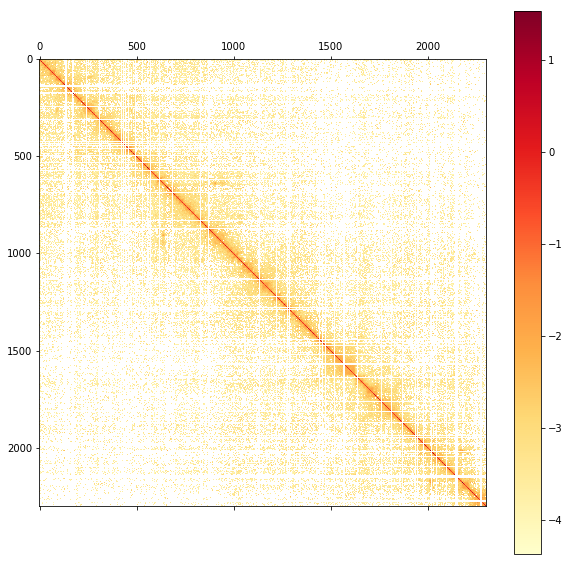

In [330]:
# plots before data cleaning
plot_hic(current_matrix)

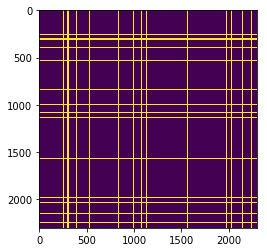

In [331]:
plt.imshow(np.isnan(current_matrix))

In [332]:
# clean the data
mark_nans_as_zeros(current_matrix)
mark_defective_as_nan(current_matrix)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


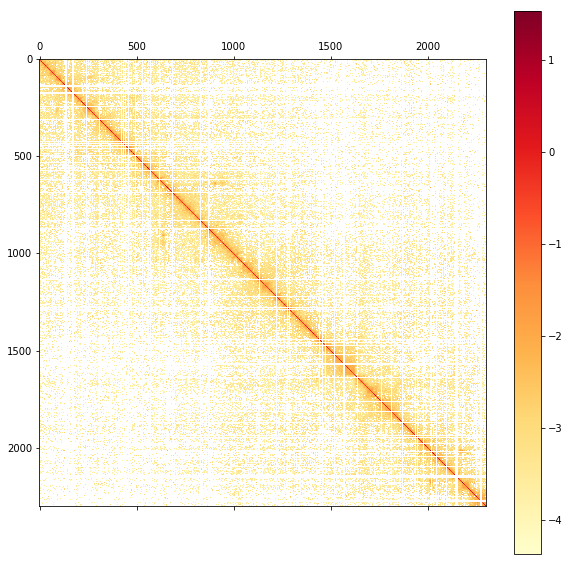

In [333]:
# plots after data cleaning
plot_hic(current_matrix)

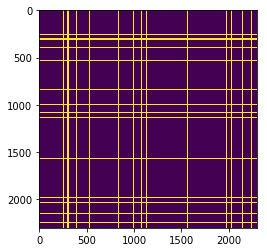

In [334]:
plt.imshow(np.isnan(current_matrix))

In [335]:
resulting_matrices, visualization_matrix = extract_good_regions(current_matrix)

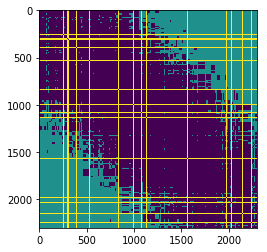

In [336]:
plt.imshow(visualization_matrix)

In [28]:
# forms train and test subsets from one submatrix
# Version 1: Only upper and lower cells are considered
# TODO: Square feature selection
def form_train_subset_v1(matrix):
    # this is a tunable parameter
    # could be 4 or much more
    # only 2 neighboring cells for training for now
    number_of_features = 2
    
    # the submatrix is too small to form training set
    if matrix.shape[0] < (number_of_features + 1):
        return (None, None)
    
    cut_indices = np.arange((number_of_features + 1), matrix.shape[0], step = (number_of_features + 1))
    
    submatrices = np.split(matrix, cut_indices)
    
    # first train_x and train_y (outside of the loop)
    train_x = np.delete(submatrices[0], (number_of_features // 2), axis = 0)
    train_y = submatrices[0][(number_of_features // 2), :]
    
    for submatrice in submatrices[1:]:
        # if clause to avoid the last not full chunk
        if submatrice.shape[0] == (number_of_features + 1):
            # (number_of_features / 2) - center position (label values)
            train_x = np.concatenate((train_x, np.delete(submatrice, (number_of_features // 2), axis = 0)), axis = 1)
            train_y = np.concatenate((train_y, submatrice[(number_of_features // 2), ]))
        
    # x - features, y - labels
    return (train_x, train_y.T)

In [29]:
# Testing form_train_subset_v1

train_subset_x, train_subset_y = form_train_subset_v1(resulting_matrices[0])

print("One of the good matrices:")
print(resulting_matrices[0])
print("Train x from this matrix:")
print(train_subset_x)
print("Train y from this matrix:")
print(train_subset_y)

One of the good matrices:
[[0.00328463 0.00160834 0.00284368 0.00115046 0.00186044 0.00277304
  0.00242126 0.         0.00213596 0.00241674 0.00099527 0.00136441
  0.00610828 0.00786418 0.00066956 0.         0.0018027 ]
 [0.00265809 0.00193683 0.0023743  0.00182878 0.00295735 0.00200364
  0.0018661  0.00231308 0.00133755 0.00201783 0.00191767 0.00144591
  0.00264811 0.00210453 0.0011611  0.00059751 0.00086835]
 [0.00137656 0.0016851  0.00248283 0.00150671 0.00146192 0.
  0.00126841 0.00054686 0.00279738 0.00042201 0.00208554 0.00142953
  0.0031999  0.00320425 0.00140304 0.00129962 0.00188874]
 [0.0022653  0.00196796 0.00168704 0.00159967 0.00144864 0.00138808
  0.00161599 0.00174179 0.00106919 0.00179219 0.00210349 0.00151772
  0.00067946 0.00213836 0.00126616 0.00096586 0.00100263]
 [0.00278943 0.00273172 0.00120748 0.00195403 0.00197494 0.00117748
  0.00308433 0.00088652 0.0027209  0.00034206 0.00169043 0.0011587
  0.00129684 0.00111309 0.00255878 0.00316024 0.00229637]
 [0.00161304 

In [427]:
# iterate over all resulting matrices and concatenate results of form_train_subset_v1 function results

train_x = np.array([]).reshape(2, 0)
train_y = np.array([]).reshape(0, )

for resulting_matrice in resulting_matrices:
    temp_train_x, temp_train_y = form_train_subset_v1(resulting_matrice)
    
    if temp_train_x is not None and temp_train_y is not None:
        train_x = np.concatenate((train_x, temp_train_x), axis = 1)
        train_y = np.concatenate((train_y, temp_train_y))

# to make 2D numpy array from the (m, ) vector
train_y = np.atleast_2d(train_y)        

print(train_x.shape)
print(train_y.shape)

normalized_train_x, old_min, old_max = min_max_normalize(train_x)

### Training set formed ###

(2, 898352)
(1, 898352)


In [451]:
# TODO: save this training set (x and y) and old_min, old_max values

print(old_min)
print(old_max)

0.0
0.13144750070493552


In [ ]:
### Model construction (Shallow Neural Network) ###

In [30]:
def create_placeholders(n_x):
    X = tf.placeholder(tf.float32, [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, [1, None], name = "Y")
    
    return X, Y

In [31]:
def initialize_parameters():
    """
    Number of hidden units is selected according to Huang et al. (2003) article
    https://www.researchgate.net/post/In_neural_networks_model_which_number_of_hidden_units_to_select
    """
    
    # xavier - рассчитан ли на 0...1 ?
    # аргумент про маленькие числа не пойдет
    
    W1 = tf.get_variable("W1", [4, 2], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [4, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [2, 4], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [2, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1, 2], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [1, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [32]:
def forward_propagation(X, parameters):
    """
    LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.matmul(W1, X) + b1                                              
    A1 = tf.nn.relu(Z1)                                              
    Z2 = tf.matmul(W2, A1) + b2                                             
    A2 = tf.nn.relu(Z2)                                             
    Z3 = tf.matmul(W3, A2) + b3
    
    return Z3

In [33]:
def compute_cost(Z3, Y):
    """
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (1, number of examples)
    Y -- "true" HI-C values, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # MSE
    cost = tf.reduce_mean(tf.square(Y - Z3))
    
    return cost

In [34]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [35]:
def model(X_train, Y_train, learning_rate = 0.00001,
          num_epochs = 10000, minibatch_size = 64, print_cost = True):
    """
    Three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    
    seed = 3                                          # to create random minibatches 
    
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    costs = []                                        # To keep track of the cost
    

    X, Y = create_placeholders(n_x)
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session(config = config) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # The line that runs the graph on a minibatch.
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost * 10000000))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost * 10000000)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per five)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        return parameters

In [ ]:
parameters_normalized = model(normalized_train_x, train_y)
# save_parameters(parameters_normalized, 'parameters_normalized.npy')

# TODO: сравнивать с dev set error
# TODO: Consider early stopping, add second graph with performance on the dev set - too early

# Colab specific code
# save_parameters(parameters_normalized, 'drive/My Drive/Colab Notebooks/parameters_normalized_shallow.npy')

In [ ]:
parameters_without = model(train_x, train_y)
# save_parameters(parameters_without, 'parameters_without.npy')

# Colab specific code
# save_parameters(parameters_without, 'drive/My Drive/Colab Notebooks/parameters_without_shallow.npy')

In [36]:
def predict(X, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    
    # only 2 parameters for now
    x = tf.placeholder("float", [2, None])
    z3 = forward_propagation(x, params)
    
    sess = tf.Session()
    predictions = sess.run(z3, feed_dict = {x: X})
    
    return predictions

In [37]:
def predict_row(original_matrix, row_idx, model_to_use):
    return predict(np.atleast_2d([original_matrix[row_idx - 1, ], original_matrix[row_idx + 1, ]]), model_to_use)

In [38]:
# Restoring Hi-C matrix with NN predictions
def restore_hic(original_matrix, model_to_use):
    predicted_matrix = np.copy(original_matrix)
    
    for i in range(1, original_matrix.shape[0] - 1):
        predicted_matrix[i, ] = predict_row(original_matrix, i, model_to_use)
        print(f"Row {i} is predicted")
    
    return predicted_matrix

In [ ]:
# Shallow model testing

In [157]:
loaded_parameters = load_parameters('parameters_normalized_shallow.npy')

In [158]:
# DON"T FORGET TO INPUT THESE VALUES
old_min = 0
old_max = 0.13144750070493552

Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted
Row 15 is predicted
Row 16 is predicted
Row 17 is predicted
Row 18 is predicted
Row 19 is predicted
Row 20 is predicted
Row 21 is predicted
Row 22 is predicted


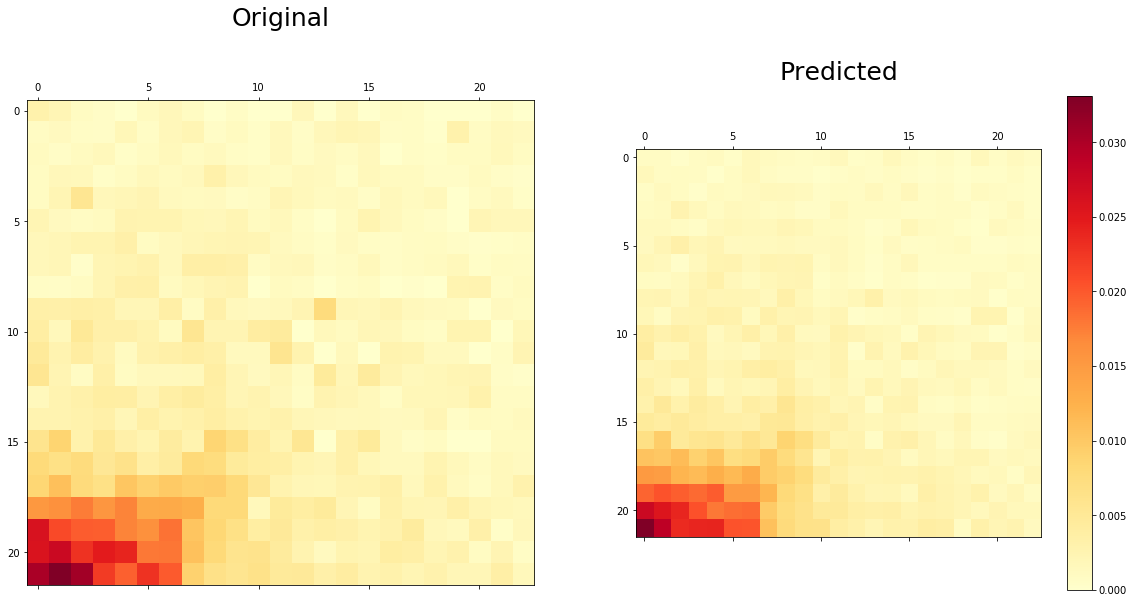

In [136]:
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[57], old_min, old_max)
restored_hic1_shallow = restore_hic(normalized_test_matrix, loaded_parameters)

plot_two_hic_same_scale(resulting_matrices[57][1:-1, ], restored_hic1_shallow[1:-1, ], use_log_scale=False)

Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted
Row 15 is predicted
Row 16 is predicted
Row 17 is predicted


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


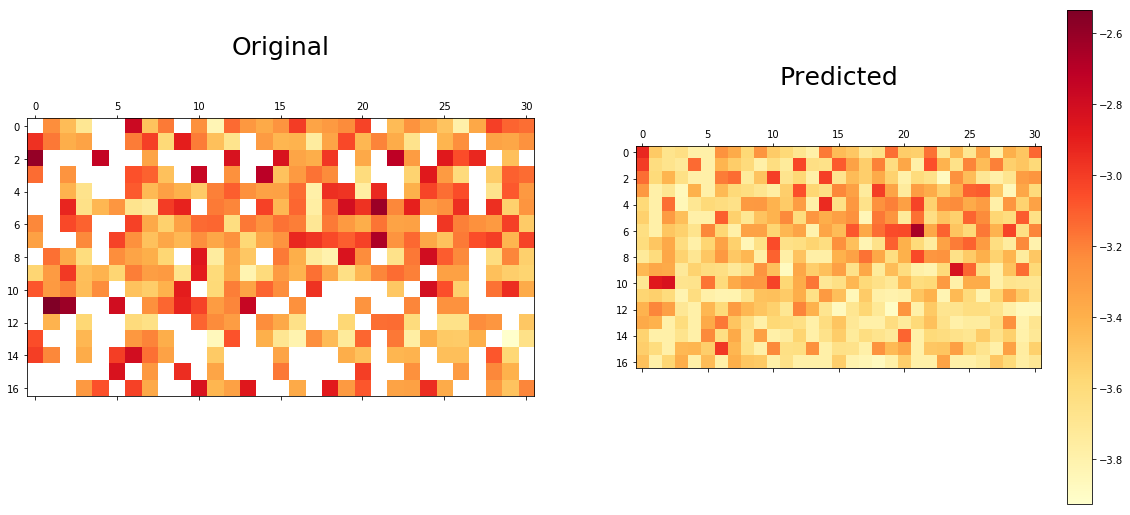

In [159]:
# predict on sparse matrix
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[488], old_min, old_max)
restored_hic2_shallow = restore_hic(normalized_test_matrix, loaded_parameters)

# Логарифмическая шкала
plot_two_hic_same_scale(resulting_matrices[488][1:-1, ], restored_hic2_shallow[1:-1, ])

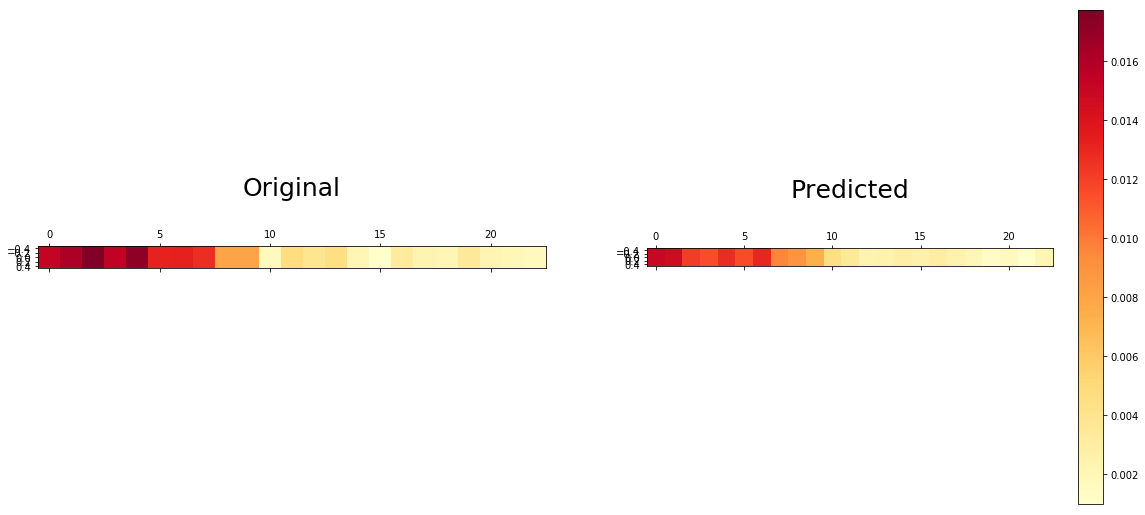

In [135]:
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[57], old_min, old_max)

# TODO: check, maybe None is returned from the function
predicted_row_shallow = predict_row(normalized_test_matrix, 19, loaded_parameters)
        
plot_two_hic_same_scale(resulting_matrices[57][19:20, ], predicted_row_shallow[0:1, ], use_log_scale=False)

In [137]:
# Count RMSE on resulting_matrices[57]
rmse(resulting_matrices[57][1:-1, ], restored_hic1_shallow[1:-1, ])

0.0014751725131872413

In [138]:
# Count R^2 on predicted_row_deep (resulting_matrices[57] on row #19)
r_squared(resulting_matrices[57][19:20, ], predicted_row_shallow[0:1, ])

0.86726698348082

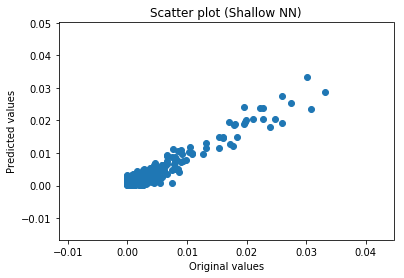

In [139]:
# Draw scatter plot on resulting_matrices[57]
scatter_plot(resulting_matrices[57][1:-1, ], restored_hic1_shallow[1:-1, ], plot_name = 'Scatter plot (Shallow NN)')

In [ ]:
# Diagonal features NN

In [439]:
'''
forms train and test subsets from one submatrix
Version 1.5: The Diagonal of neighboring features is considered

square_size = 1 => 6 features

    1 1
     *
    1 1

square_size = 2 => 20 features

    1   1
     1 1 
      * 
     1 1 
    1   1

'''
def form_train_subset_diagonal(matrix, square_size):
    square_h_w = square_size * 2 + 1
    
    # the submatrix is too small to form training set
    if matrix.shape[0] < square_h_w or matrix.shape[1] < square_h_w:
        return (None, None)
    
    # TODO: relevant only for square_size = 2
    number_of_features = 8
    
    # This is a tunable parameter
    # FUTURE WORK: try stride of 1 (might be better)
    stride = 2
    row_submatrices = [matrix[i:i + square_h_w, ] for i in range(0, matrix.shape[0] - (square_h_w - 1), stride)]
    
    train_x = np.array([]).reshape(number_of_features, 0)
    train_y = []
    
    for row_submatrice in row_submatrices:
        
        column_submatrices = [row_submatrice[:, i:i + square_h_w] for i in range(0, matrix.shape[1] - (square_h_w - 1), stride)]
        
        for column_submatrice in column_submatrices:
            sur = np.delete(column_submatrice, (square_h_w // 2), axis = 0)
            # TODO: relevant only for square_size = 2
            diagonal_features = np.array([sur[0, 0], sur[0, 4], sur[1, 1], sur[1, 3], sur[2, 1], sur[2, 3], sur[3, 0], sur[3, 4]])
            
            train_x = np.concatenate((train_x, diagonal_features.reshape((number_of_features, 1))), axis = 1)
            
            # don't use center row elements for training - they will be empty in the test set
            train_y.append(column_submatrice[(square_h_w // 2), :][square_h_w // 2])
    
    # x - features, y - labels
    return (train_x, np.array(train_y))

In [440]:
# relevant only for square_size = 2
train_x_diagonal = np.array([]).reshape(8, 0)
train_y_diagonal = np.array([]).reshape(0, )

SQUARE_SIZE = 2

for resulting_matrice in resulting_matrices:
    temp_train_x_diagonal, temp_train_y_diagonal = form_train_subset_diagonal(resulting_matrice, SQUARE_SIZE)
    
    if temp_train_x_diagonal is not None and temp_train_y_diagonal is not None:
        train_x_diagonal = np.concatenate((train_x_diagonal, temp_train_x_diagonal), axis = 1)
        train_y_diagonal = np.concatenate((train_y_diagonal, temp_train_y_diagonal))

# to make 2D numpy array from the (m, ) vector
train_y_diagonal = np.atleast_2d(train_y_diagonal)

print(train_x_diagonal.shape)
print(train_y_diagonal.shape)

normalized_train_x_diagonal, old_min_diagonal, old_max_diagonal = min_max_normalize(train_x_diagonal)

### Training set diagonal formed ###

(8, 444254)
(1, 444254)


In [457]:
# TODO: save this training set (x and y) and old_min_v2, old_max_v2 values
print(old_min_v2)
print(old_max_v2)

0.0
0.20463208670374058


In [458]:
### Model construction (Shallow Neural Network) ###

def initialize_parameters_diagonal():
    W1 = tf.get_variable("W1", [30, 8], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [30, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable("W4", [30, 30], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b4", [30, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable("W5", [1, 30], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b5", [1, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [461]:
def model_diagonal(X_train, Y_train, learning_rate = 0.000001,
          num_epochs = 1000, minibatch_size = 64, print_cost = True):
    """
    Three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    
    seed = 3                                          # to create random minibatches 
    
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    costs = []                                        # To keep track of the cost
    

    X, Y = create_placeholders(n_x)
    parameters = initialize_parameters_diagonal()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session(config = config) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # The line that runs the graph on a minibatch.
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost * 10000000))
            costs.append(epoch_cost * 10000000)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        return parameters

In [ ]:
parameters_normalized_diagonal = model_diagonal(normalized_train_x_diagonal, train_y_diagonal)

# Colab specific code
# save_parameters(parameters_normalized_diagonal, 'drive/My Drive/Colab Notebooks/parameters_normalized_diagonal.npy')

In [ ]:
parameters_without_diagonal = model_diagonal(train_x_diagonal, train_y_diagonal)

# Colab specific code
# save_parameters(parameters_without_diagonal, 'drive/My Drive/Colab Notebooks/parameters_without_diagonal.npy')

In [141]:
def predict_diagonal(X, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    
    x = tf.placeholder("float", [8, None])
    z3 = forward_propagation(x, params)
    
    sess = tf.Session()
    predictions = sess.run(z3, feed_dict = {x: X})
    
    return predictions

In [142]:
def extract_row_features_diagonal(matrix, square_h_w):
    # TODO: relevant only for square_size = 2
    number_of_features = 8
    
    train_x = np.array([]).reshape(number_of_features, 0)
        
    column_submatrices = [matrix[:, i:i + square_h_w] for i in range(0, matrix.shape[1] - (square_h_w - 1))]

    for column_submatrice in column_submatrices:        
        sur = np.delete(column_submatrice, (square_h_w // 2), axis = 0)
        
        # TODO: relevant only for square_size = 2
        diagonal_features = np.array([sur[0, 0], sur[0, 4], sur[1, 1], sur[1, 3], sur[2, 1], sur[2, 3], sur[3, 0], sur[3, 4]])

        train_x = np.concatenate((train_x, diagonal_features.reshape((number_of_features, 1))), axis = 1)

    return train_x

In [150]:
'''
For now we omit edge pixels, so predicted row becomes smaller than the original

For future, we can try to predict edge pixels using zeros as the values for the non existing features
'''
def predict_row_diagonal(original_matrix, model_to_use, square_size, row_idx):
    square_h_w = square_size * 2 + 1
    
    # check if submatrix can be obtained (not outside of bounds) - for rows and columns => return None if not
    if row_idx < (square_h_w // 2) or original_matrix.shape[0] - (row_idx + 1) < (square_h_w // 2) or original_matrix.shape[1] < square_h_w:
            return None
    
    # extract features for the given row
    row_features = extract_row_features_diagonal(original_matrix[(row_idx - (square_h_w // 2)):(row_idx + (square_h_w // 2)) + 1, :], 
                                        square_h_w)
    
    return predict_diagonal(row_features, model_to_use)

In [151]:
# Restoring Hi-C matrix with diagonal NN predictions
def restore_hic_diagonal(original_matrix, model_to_use, square_size):
    predicted_matrix = np.copy(original_matrix[2:-2, 2:-2])
    
    for i in range(0, predicted_matrix.shape[0]):
        # TODO: check, maybe None is returned from the function
        predicted_matrix[i, ] = predict_row_diagonal(original_matrix, model_to_use, square_size, i + square_size)
        print(f"Row {i} is predicted")
    
    return predicted_matrix

In [152]:
# Diagonal model testing

In [162]:
loaded_parameters = load_parameters('parameters_normalized_diagonal.npy')

In [163]:
# DON"T FORGET TO INPUT THESE VALUES
old_min = 0
old_max = 0.20463208670374058

Row 0 is predicted
Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted
Row 15 is predicted
Row 16 is predicted
Row 17 is predicted
Row 18 is predicted
Row 19 is predicted


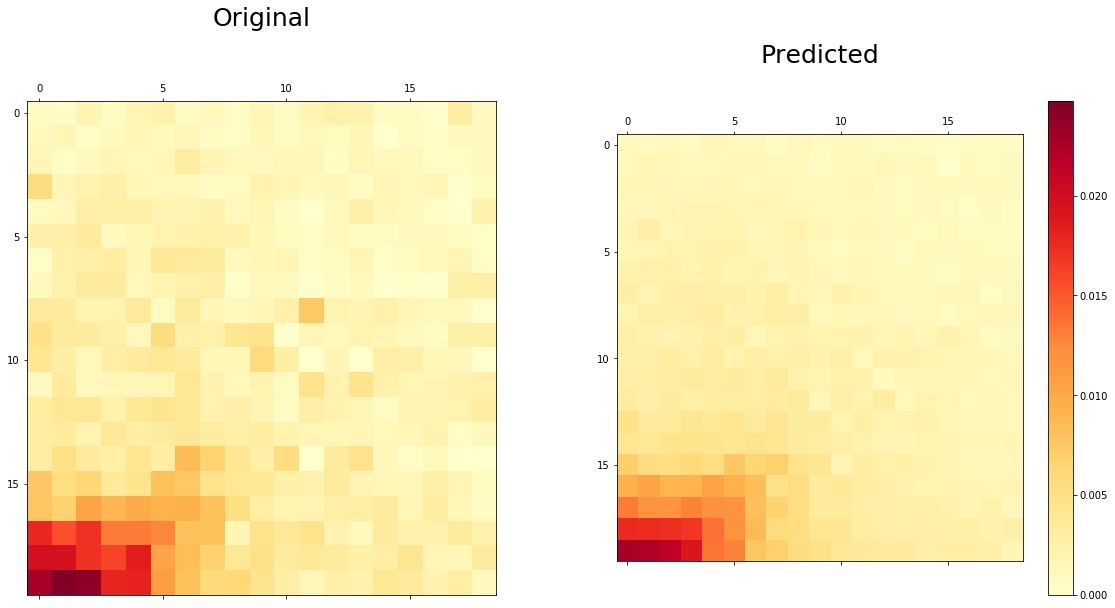

In [155]:
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[57], old_min, old_max)
restored_hic1_diagonal = restore_hic_diagonal(normalized_test_matrix, loaded_parameters, SQUARE_SIZE)

plot_two_hic_same_scale(resulting_matrices[57][2:-2, 2:-2], restored_hic1_diagonal, use_log_scale=False)

Row 0 is predicted
Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


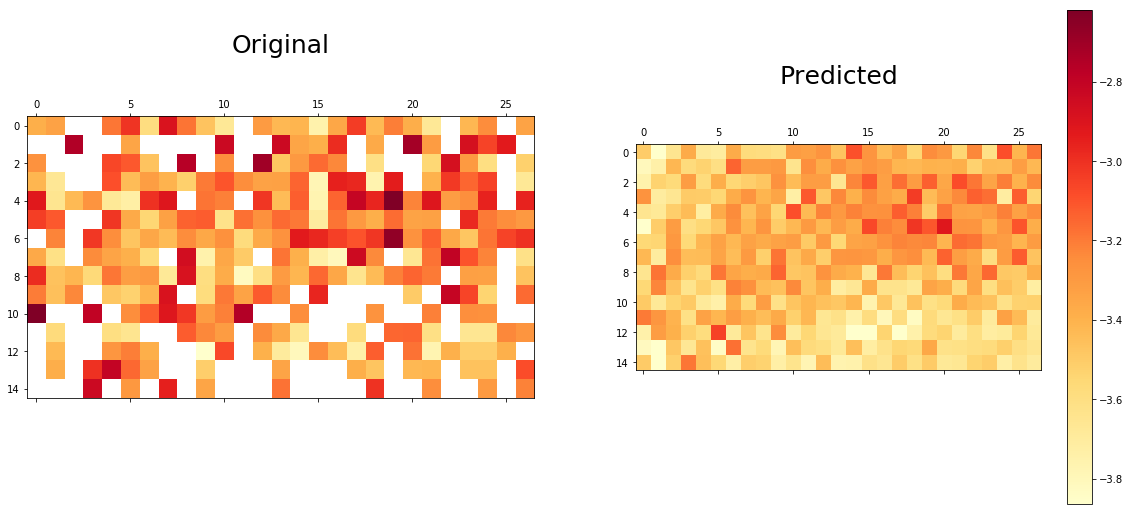

In [164]:
# predict on sparse matrix
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[488], old_min, old_max)
restored_hic2_diagonal = restore_hic_diagonal(normalized_test_matrix, loaded_parameters, SQUARE_SIZE)

# логарифмическая шкала
plot_two_hic_same_scale(resulting_matrices[488][2:-2, 2:-2], restored_hic2_diagonal)

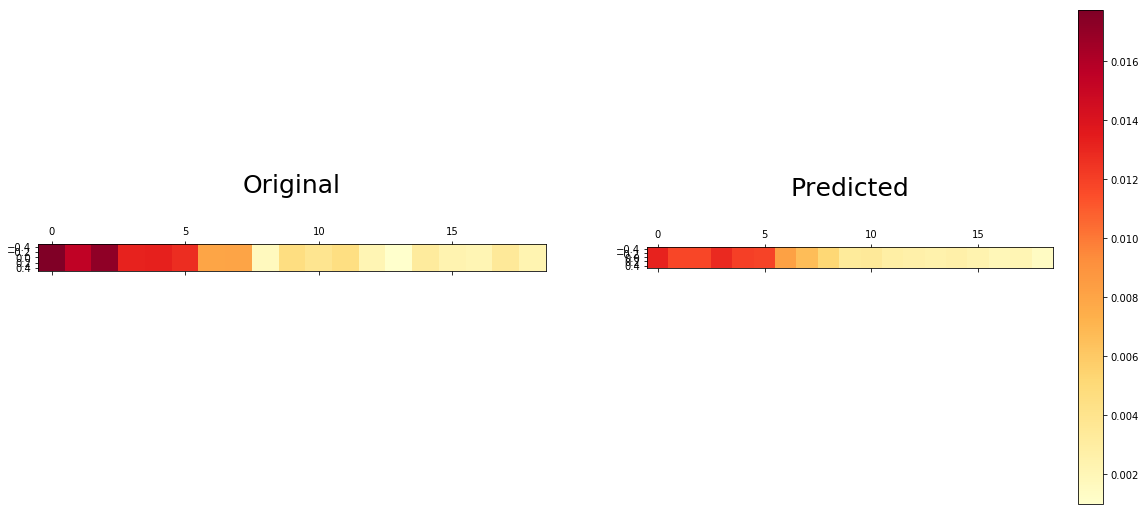

In [165]:
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[57], old_min, old_max)

# TODO: check, maybe None is returned from the function
predicted_row_diagonal = predict_row_diagonal(normalized_test_matrix, loaded_parameters, SQUARE_SIZE, 19)
        
plot_two_hic_same_scale(resulting_matrices[57][19:20, 2:-2], predicted_row_diagonal[0:1, ], use_log_scale=False)

In [166]:
# Count RMSE on resulting_matrices[57]
rmse(resulting_matrices[57][2:-2, 2:-2], restored_hic1_diagonal)

0.0012831970564400087

In [167]:
# Count R^2 on predicted_row_deep (resulting_matrices[57] on row #19)
r_squared(resulting_matrices[57][19:20, 2:-2], predicted_row_diagonal[0:1, ])

0.8496322759650354

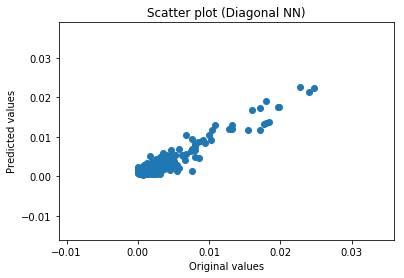

In [168]:
# Draw scatter plot on resulting_matrices[57]
scatter_plot(resulting_matrices[57][2:-2, 2:-2], restored_hic1_diagonal, plot_name = 'Scatter plot (Diagonal NN)')

In [ ]:
# Second part of the work
# Try deeper NN and the square of features

In [337]:
'''
forms train and test subsets from one submatrix
Version 2: The Square of neighboring features is considered

square_size = 1 => 6 features

    111
    1*1
    111

square_size = 2 => 20 features

    11111
    11111
    11*11
    11111
    11111

'''
def form_train_subset_v2(matrix, square_size):
    square_h_w = square_size * 2 + 1
    
    # the submatrix is too small to form training set
    if matrix.shape[0] < square_h_w or matrix.shape[1] < square_h_w:
        return (None, None)
    
    number_of_features = (square_h_w * square_h_w) - square_h_w
    
    # This is a tunable parameter
    # FUTURE WORK: try stride of 1 (might be better)
    stride = 2
    row_submatrices = [matrix[i:i + square_h_w, ] for i in range(0, matrix.shape[0] - (square_h_w - 1), stride)]
    
    train_x = np.array([]).reshape(number_of_features, 0)
    train_y = []
    
    for row_submatrice in row_submatrices:
        
        column_submatrices = [row_submatrice[:, i:i + square_h_w] for i in range(0, matrix.shape[1] - (square_h_w - 1), stride)]
        
        for column_submatrice in column_submatrices:
            surrounding_square = np.delete(column_submatrice, (square_h_w // 2), axis = 0)
            train_x = np.concatenate((train_x, surrounding_square.reshape((number_of_features, 1))), axis = 1)
            
            # don't use center row elements for training - they will be empty in the test set
            train_y.append(column_submatrice[(square_h_w // 2), :][square_h_w // 2])
    
    # x - features, y - labels
    return (train_x, np.array(train_y))

In [338]:
# iterate over all resulting matrices and concatenate results of form_train_subset_v2 function results

# relevant only for square_size = 2
train_x_v2 = np.array([]).reshape(20, 0)
train_y_v2 = np.array([]).reshape(0, )

SQUARE_SIZE = 2

for resulting_matrice in resulting_matrices:
    temp_train_x_v2, temp_train_y_v2 = form_train_subset_v2(resulting_matrice, SQUARE_SIZE)
    
    if temp_train_x_v2 is not None and temp_train_y_v2 is not None:
        train_x_v2 = np.concatenate((train_x_v2, temp_train_x_v2), axis = 1)
        train_y_v2 = np.concatenate((train_y_v2, temp_train_y_v2))

# to make 2D numpy array from the (m, ) vector
train_y_v2 = np.atleast_2d(train_y_v2)

print(train_x_v2.shape)
print(train_y_v2.shape)

normalized_train_x_v2, old_min_v2, old_max_v2 = min_max_normalize(train_x_v2)

### Training set V2 formed ###

(20, 446926)
(1, 446926)


In [339]:
# TODO: save this training set (x and y) and old_min_v2, old_max_v2 values
print(old_min_v2)
print(old_max_v2)

0.0
0.20463208670374058


In [ ]:
# TODO:

# split dataset in train and validation
# plot cost curve each epoch with both training and validation sets
# add regularization to the model

In [42]:
### Model construction (Deep Neural Network) ###

'''
TODO: estimate optimal number of hidden layers / hidden units - experiments needed

Andrew NG: "Reasonable default is one hidden layer, or if > 1 hidden layer, 
have the same number of hidden units in every layer 
(usually the more the better, anywhere from about 1X to 4X the number of input units)."

https://stats.stackexchange.com/questions/99828/when-is-a-second-hidden-layer-needed-in-feed-forward-neural-networks
'''
def initialize_parameters_v2():
    W1 = tf.get_variable("W1", [80, 20], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [80, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable("W2", [80, 80], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [80, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable("W3", [80, 80], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [80, 1], initializer = tf.zeros_initializer())
    
    W4 = tf.get_variable("W4", [80, 80], initializer = tf.contrib.layers.xavier_initializer())
    b4 = tf.get_variable("b4", [80, 1], initializer = tf.zeros_initializer())
    
    W5 = tf.get_variable("W5", [1, 80], initializer = tf.contrib.layers.xavier_initializer())
    b5 = tf.get_variable("b5", [1, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4,
                  "W5": W5,
                  "b5": b5}
    
    return parameters

In [43]:
def forward_propagation_v2(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
    
    Z1 = tf.matmul(W1, X) + b1                                              
    A1 = tf.nn.relu(Z1)                                              
    
    Z2 = tf.matmul(W2, A1) + b2                                             
    A2 = tf.nn.relu(Z2)
    
    Z3 = tf.matmul(W3, A2) + b3                                              
    A3 = tf.nn.relu(Z3)
    
    Z4 = tf.matmul(W4, A3) + b4                                             
    A4 = tf.nn.relu(Z4)
    
    Z5 = tf.matmul(W5, A4) + b5                                             
    
    return Z5

In [44]:
def compute_cost_v2(Z5, Y):    
    # MSE
    cost = tf.reduce_mean(tf.square(Y - Z5))
    
    return cost

In [45]:
def model_v2(X_train, Y_train, learning_rate = 0.000001,
          num_epochs = 1000, minibatch_size = 64, print_cost = True):
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    
    seed = 3                                          # to create random minibatches
    
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    costs = []                                        # To keep track of the cost

    X, Y = create_placeholders(n_x)
    parameters = initialize_parameters_v2()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z5 = forward_propagation_v2(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost_v2(Z5, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session(config = config) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # The line that runs the graph on a minibatch.
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches


            print ("Cost after epoch %i: %f" % (epoch, epoch_cost * 10000000))
            costs.append(epoch_cost * 10000000)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per five)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        return parameters

In [ ]:
parameters_normalized_v2 = model_v2(normalized_train_x_v2, train_y_v2)

# Colab specific code
# save_parameters(parameters_normalized_v2, 'drive/My Drive/Colab Notebooks/parameters_normalized_deep.npy')

In [ ]:
parameters_without_v2 = model_v2(train_x_v2, train_y_v2)

# Colab specific code
# save_parameters(parameters_without_v2, 'drive/My Drive/Colab Notebooks/parameters_without_deep.npy')

In [46]:
def predict_v2(X, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    W4 = tf.convert_to_tensor(parameters["W4"])
    b4 = tf.convert_to_tensor(parameters["b4"])
    W5 = tf.convert_to_tensor(parameters["W5"])
    b5 = tf.convert_to_tensor(parameters["b5"])
    
    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3,
             "W4": W4, "b4": b4, "W5": W5, "b5": b5}
    
    # only 2 parameters for now
    x = tf.placeholder("float", [20, None])
    z5 = forward_propagation_v2(x, params)
    
    sess = tf.Session()
    predictions = sess.run(z5, feed_dict = {x: X})
    
    return predictions

In [47]:
def extract_row_features(matrix, square_h_w):
    number_of_features = (square_h_w * square_h_w) - square_h_w
    
    train_x = np.array([]).reshape(number_of_features, 0)
        
    column_submatrices = [matrix[:, i:i + square_h_w] for i in range(0, matrix.shape[1] - (square_h_w - 1))]

    for column_submatrice in column_submatrices:
        surrounding_square = np.delete(column_submatrice, (square_h_w // 2), axis = 0)
        train_x = np.concatenate((train_x, surrounding_square.reshape((number_of_features, 1))), axis = 1)

    return train_x

In [48]:
'''
For now we omit edge pixels, so predicted row becomes smaller than the original

For future, we can try to predict edge pixels using zeros as the values for the non existing features
'''
def predict_row_v2(original_matrix, model_to_use, square_size, row_idx):
    square_h_w = square_size * 2 + 1
    
    # check if submatrix can be obtained (not outside of bounds) - for rows and columns => return None if not
    if row_idx < (square_h_w // 2) or original_matrix.shape[0] - (row_idx + 1) < (square_h_w // 2) or original_matrix.shape[1] < square_h_w:
            return None
    
    # extract features for the given row
    row_features = extract_row_features(original_matrix[(row_idx - (square_h_w // 2)):(row_idx + (square_h_w // 2)) + 1, :], 
                                        square_h_w)
    
    return predict_v2(row_features, model_to_use)

In [49]:
# Restoring Hi-C matrix with deep NN predictions
def restore_hic_v2(original_matrix, model_to_use, square_size):
    predicted_matrix = np.copy(original_matrix[2:-2, 2:-2])
    
    for i in range(0, predicted_matrix.shape[0]):
        # TODO: check, maybe None is returned from the function
        predicted_matrix[i, ] = predict_row_v2(original_matrix, model_to_use, square_size, i + square_size)
        print(f"Row {i} is predicted")
    
    return predicted_matrix

In [50]:
def plot_two_hic_same_scale(original, predicted, use_log_scale = True):
    fig = plt.figure(figsize=(20, 20))
    
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    
    ax1.set_title("Original", fontsize=25, pad=50)
    ax2.set_title("Predicted", fontsize=25, pad=50)
    
    if use_log_scale:
        # to get rid of possible -inf
        masked_log10 = np.ma.masked_invalid(np.log10(original))
        
        v_min_value, v_max_value = np.min(masked_log10), np.max(masked_log10)
        
        im1 = ax1.matshow(np.log10(original), cmap='YlOrRd', vmin=v_min_value, vmax=v_max_value)
        im2 = ax2.matshow(np.log10(predicted), cmap='YlOrRd', vmin=v_min_value, vmax=v_max_value)
    
        fig.colorbar(im1)
    else:
        v_min_value, v_max_value = np.min(original), np.max(original)
        
        im1 = ax1.matshow(original, cmap='YlOrRd', vmin=v_min_value, vmax=v_max_value)
        im2 = ax2.matshow(predicted, cmap='YlOrRd', vmin=v_min_value, vmax=v_max_value)
    
        fig.colorbar(im1)

In [ ]:
# Deep model testing

In [156]:
loaded_parameters = load_parameters('parameters_normalized_deep.npy')

In [387]:
# DON"T FORGET TO INPUT THESE VALUES
old_min = 0
old_max = 0.20463208670374058

SQUARE_SIZE = 2

Row 0 is predicted
Row 1 is predicted
Row 2 is predicted
Row 3 is predicted


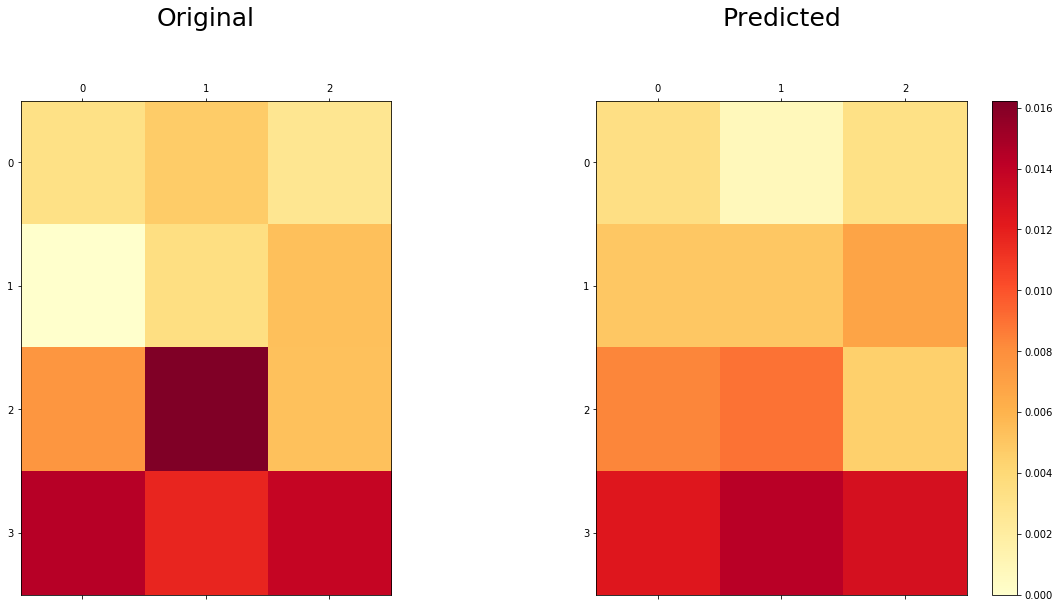

In [84]:
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[8], old_min, old_max)
restored_hic1_deep = restore_hic_v2(normalized_test_matrix, loaded_parameters, SQUARE_SIZE)

plot_two_hic_same_scale(resulting_matrices[8][2:-2, 2:-2], restored_hic1_deep, use_log_scale=False)

Row 0 is predicted
Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted


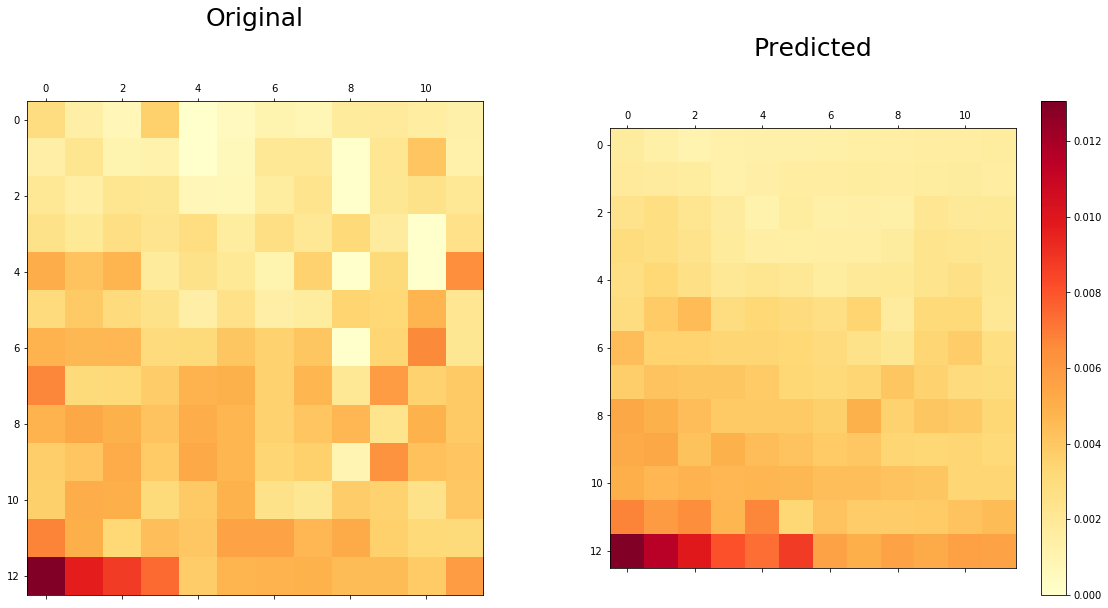

In [83]:
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[72], old_min, old_max)
restored_hic2_deep = restore_hic_v2(normalized_test_matrix, loaded_parameters, SQUARE_SIZE)

plot_two_hic_same_scale(resulting_matrices[72][2:-2, 2:-2], restored_hic2_deep, use_log_scale=False)

Row 0 is predicted
Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted
Row 15 is predicted
Row 16 is predicted
Row 17 is predicted
Row 18 is predicted
Row 19 is predicted


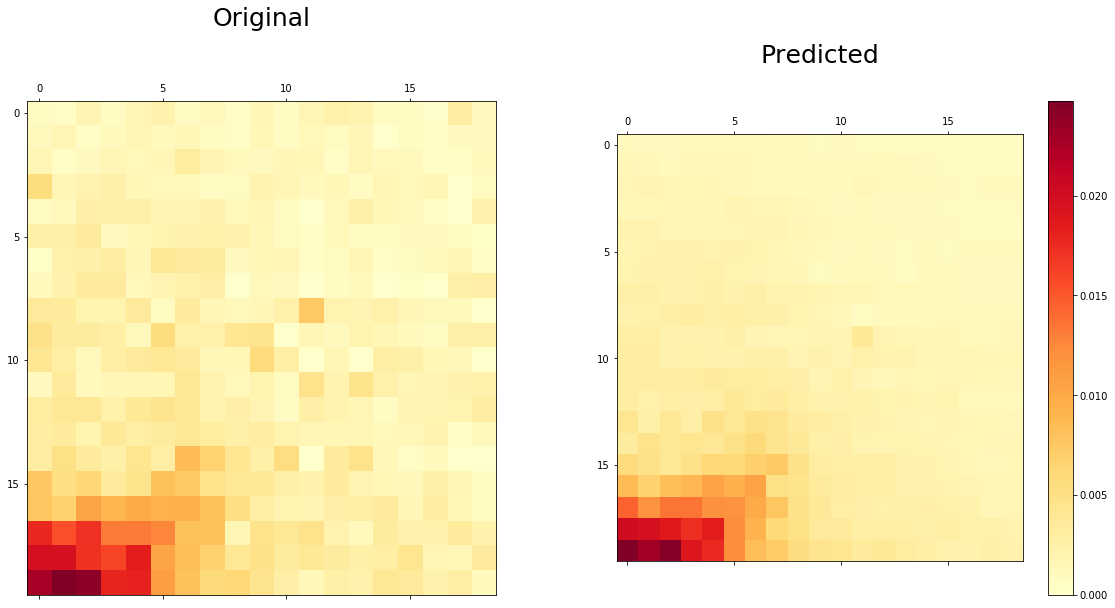

In [169]:
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[57], old_min, old_max)
restored_hic3_deep = restore_hic_v2(normalized_test_matrix, loaded_parameters, SQUARE_SIZE)

plot_two_hic_same_scale(resulting_matrices[57][2:-2, 2:-2], restored_hic3_deep, use_log_scale=False)

Row 0 is predicted
Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted
Row 15 is predicted
Row 16 is predicted
Row 17 is predicted
Row 18 is predicted
Row 19 is predicted
Row 20 is predicted
Row 21 is predicted
Row 22 is predicted
Row 23 is predicted
Row 24 is predicted
Row 25 is predicted
Row 26 is predicted
Row 27 is predicted
Row 28 is predicted
Row 29 is predicted
Row 30 is predicted
Row 31 is predicted
Row 32 is predicted
Row 33 is predicted
Row 34 is predicted
Row 35 is predicted
Row 36 is predicted
Row 37 is predicted
Row 38 is predicted
Row 39 is predicted


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


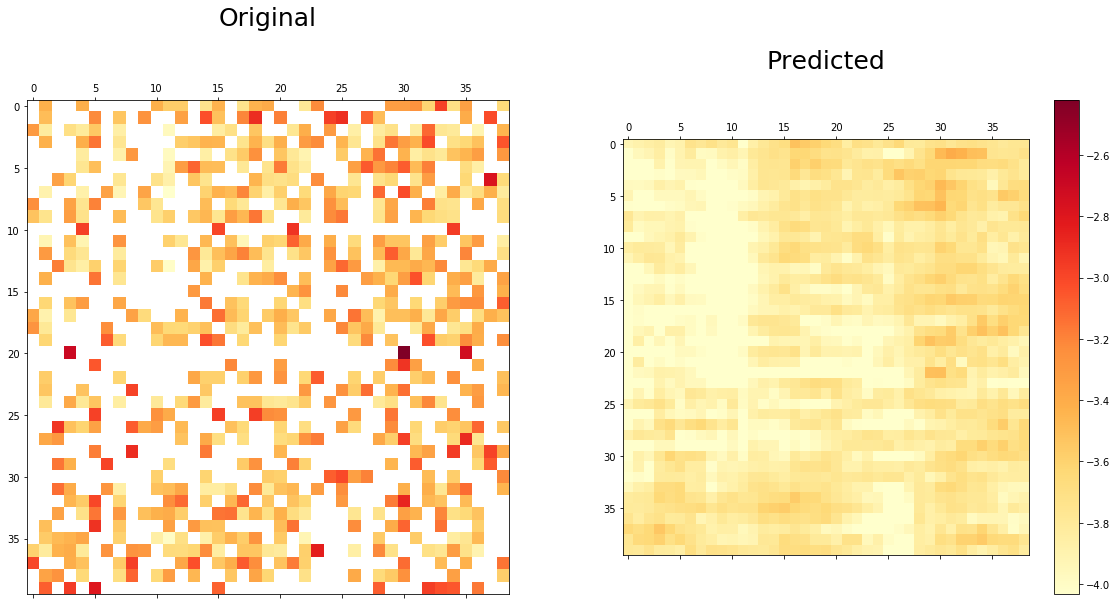

In [161]:
# predict on sparse matrix
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[488], old_min, old_max)
restored_hic4_deep = restore_hic_v2(normalized_test_matrix, loaded_parameters, SQUARE_SIZE)

# логарифмическая шкала
plot_two_hic_same_scale(resulting_matrices[488][2:-2, 2:-2], restored_hic4_deep)

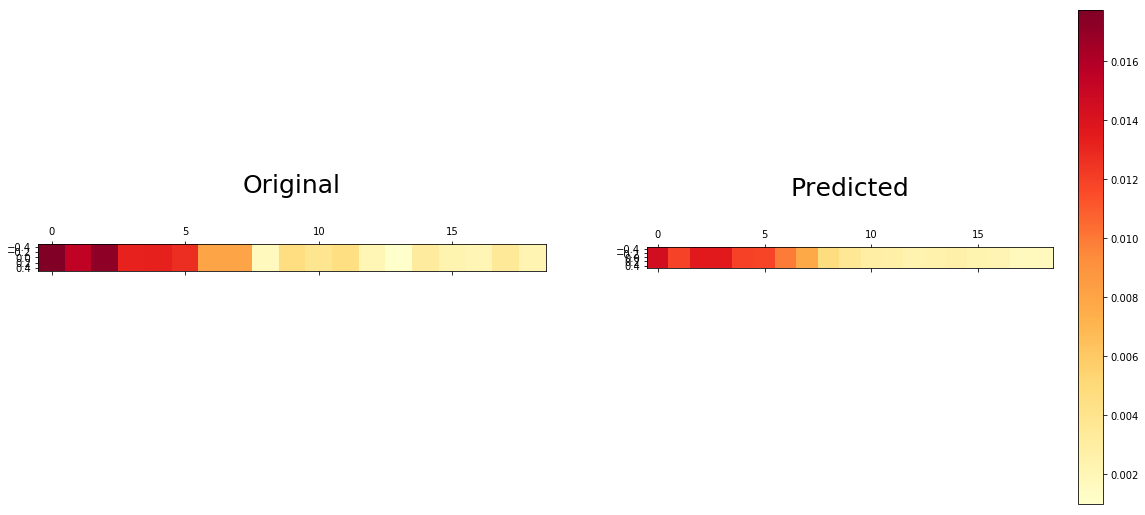

In [170]:
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[57], old_min, old_max)

# TODO: check, maybe None is returned from the function
predicted_row_deep = predict_row_v2(normalized_test_matrix, loaded_parameters, SQUARE_SIZE, 19)
        
plot_two_hic_same_scale(resulting_matrices[57][19:20, 2:-2], predicted_row_deep[0:1, ], use_log_scale=False)

In [173]:
# Count RMSE on resulting_matrices[57]
rmse(resulting_matrices[57][2:-2, 2:-2], restored_hic3_deep)

0.0011872947837800244

In [174]:
# Count R^2 on predicted_row_deep (resulting_matrices[57] on row #19)
r_squared(resulting_matrices[57][19:20, 2:-2], predicted_row_deep[0:1, ])

0.8938972024944576

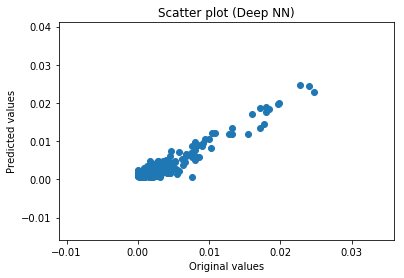

In [175]:
# Draw scatter plot on resulting_matrices[57]
scatter_plot(resulting_matrices[57][2:-2, 2:-2], restored_hic3_deep, plot_name = 'Scatter plot (Deep NN)')

In [356]:
# RMSE, R^2, Two predictions on rows (dense, sparse), whole matrix reconstructions, scatter plot
# All these procedures should be ran on all of the methods

# Evaluates Keras model on RMSE and R^2 metrics
def evaluate_model(model, chromosome):
    with open("datasets/" + chromosome + "_normalized_train_x_v2", "rb") as fp:
        test_x = pickle.load(fp)
        
    with open("datasets/" + chromosome + "_train_y_v2", "rb") as fp:
        test_y = pickle.load(fp)
        
    predictions = model.predict(test_x.T).T
    
    return rmse(test_y, predictions), r_squared(test_y, predictions)
    

def rmse(original, predicted):
    return np.sqrt(np.mean((original - predicted)**2))


# helper function for the r_squared function
def _squared_error(original, predicted):
    return np.sum((predicted - original) * (predicted - original))


def r_squared(original, predicted):
    y_mean_line = [np.mean(original) for y in original]
    
    squared_error_regr = _squared_error(original, predicted)
    squared_error_y_mean = _squared_error(original, y_mean_line)
    
    return 1 - (squared_error_regr / squared_error_y_mean)


def scatter_plot(original, predicted, plot_name = 'Default plot name'):
    plt.scatter(original, predicted)
    plt.title(plot_name)
    plt.xlabel('Original values')
    plt.ylabel('Predicted values')
    plt.show()

In [313]:
# R^2 test

# negative values -> low correlation
print(r_squared(np.array([1,2,3]), np.array([1,3,-10])))

# negative value is smaller, because third result is more expected
print(r_squared(np.array([1,2,3]), np.array([1,3,10])))

# 0.5
print(r_squared(np.array([1,2,3]), np.array([1,2,2])))

# 1
print(r_squared(np.array([1,2,3]), np.array([1,2,3])))

-84.0
-24.0
0.5
1.0


In [ ]:
# TODO: All 3 models evaluation on the different chromosome

# Calculate accuracy on the test set
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
# print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

# TODO:
# def evaluate_model(X_test, Y_test):

In [ ]:
# Keras model V1 (Without dropout, L2 regularization and Batch Normalization)

In [151]:
model = tf.keras.Sequential()

model.add(layers.Dense(80, activation='relu', input_shape=(20,)))
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss='mse',
              metrics=['mae'])

In [144]:
history = model.fit(normalized_train_x_v2.T, train_y_v2.T, epochs=3, batch_size=256)

Epoch 1/3
444511/444511 [==============================] - 15s 35us/sample - loss: 2.7955e-07 - mean_absolute_error: 2.7619e-04
Epoch 2/3
444511/444511 [==============================] - 13s 30us/sample - loss: 2.1808e-07 - mean_absolute_error: 2.6259e-04
Epoch 3/3
444511/444511 [==============================] - 12s 28us/sample - loss: 2.0566e-07 - mean_absolute_error: 2.5993e-04


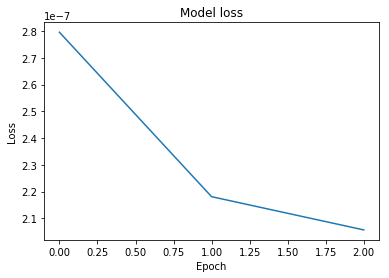

In [145]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [80]:
# Colab specific code - save the model
# model.save_weights('model_normalized_deep_keras.h5', save_format='h5')

In [100]:
'''
For now we omit edge pixels, so predicted row becomes smaller than the original

For future, we can try to predict edge pixels using zeros as the values for the non existing features
'''
def predict_row_v2_keras(original_matrix, model, square_size, row_idx):
    square_h_w = square_size * 2 + 1
    
    # check if submatrix can be obtained (not outside of bounds) - for rows and columns => return None if not
    if row_idx < (square_h_w // 2) or original_matrix.shape[0] - (row_idx + 1) < (square_h_w // 2) or original_matrix.shape[1] < square_h_w:
            return None
    
    # extract features for the given row
    row_features = extract_row_features(original_matrix[(row_idx - (square_h_w // 2)):(row_idx + (square_h_w // 2)) + 1, :], 
                                        square_h_w)
    
    return model.predict(row_features.T, batch_size=32)

In [101]:
# Restoring Hi-C matrix with deep NN predictions
def restore_hic_v2_keras(original_matrix, model, square_size):
    predicted_matrix = np.copy(original_matrix[2:-2, 2:-2])
    
    for i in range(0, predicted_matrix.shape[0]):
        # TODO: check, maybe None is returned from the function
        predicted_matrix[i, ] = predict_row_v2_keras(original_matrix, model, square_size, i + square_size).T
        print(f"Row {i} is predicted")
    
    return predicted_matrix

In [152]:
# load model
model.load_weights('model_normalized_deep_keras.h5')

In [ ]:
# Show that results are equivalent to the tf model

Row 0 is predicted
Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted
Row 15 is predicted
Row 16 is predicted
Row 17 is predicted
Row 18 is predicted
Row 19 is predicted


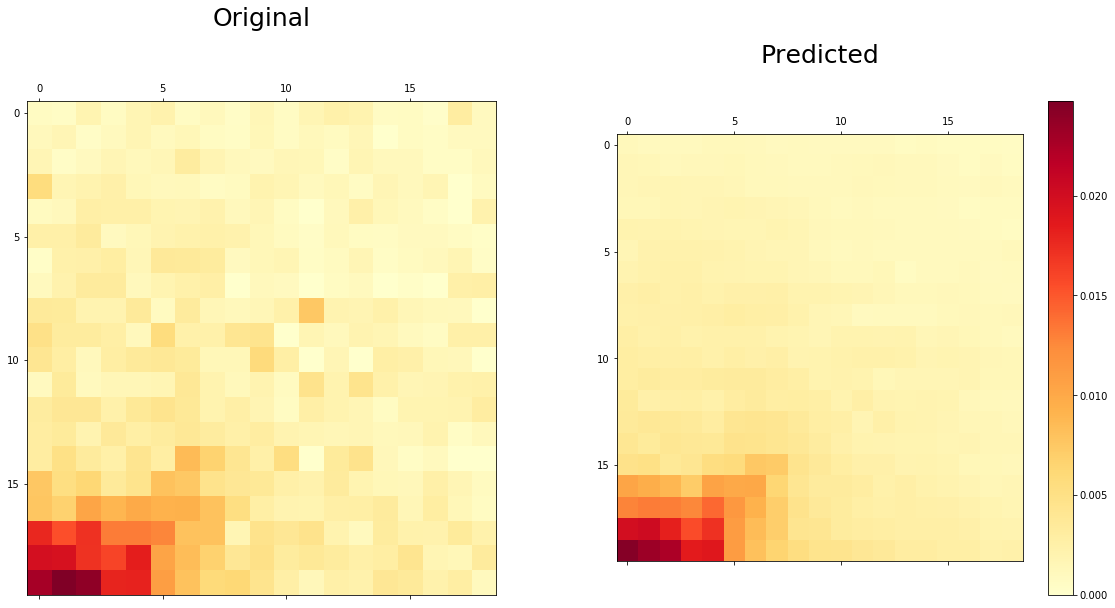

In [186]:
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[57], old_min, old_max)
restored_hic3_deep_keras = restore_hic_v2_keras(normalized_test_matrix, model, SQUARE_SIZE)

plot_two_hic_same_scale(resulting_matrices[57][2:-2, 2:-2], restored_hic3_deep_keras, use_log_scale=False)

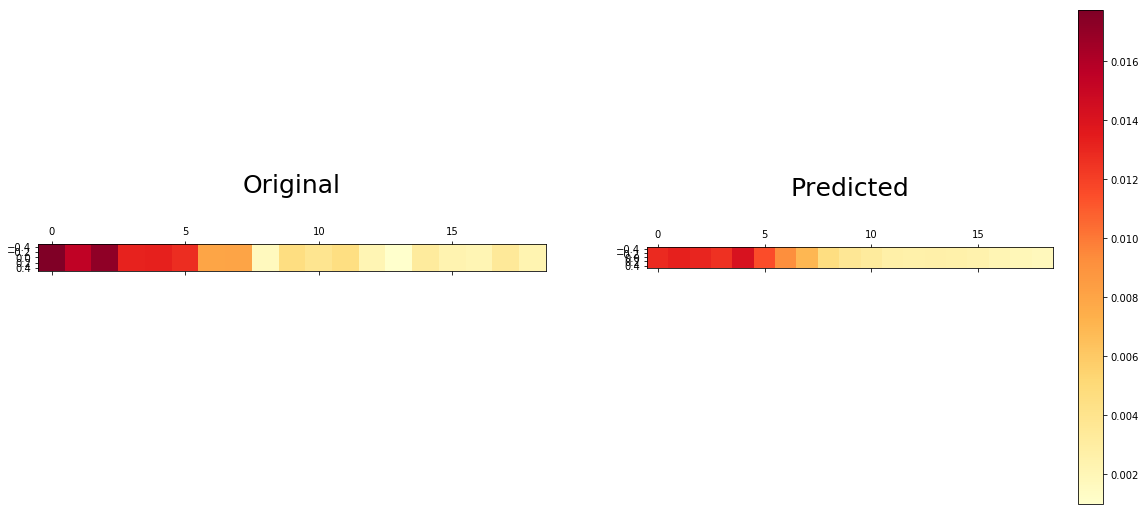

In [187]:
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[57], old_min, old_max)

# TODO: check, maybe None is returned from the function
predicted_row_deep_keras = predict_row_v2_keras(normalized_test_matrix, model, SQUARE_SIZE, 19).T
plot_two_hic_same_scale(resulting_matrices[57][19:20, 2:-2], predicted_row_deep_keras[0:1, ], use_log_scale=False)

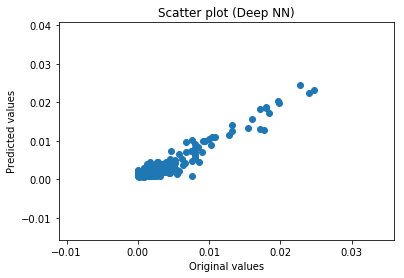

In [190]:
# Draw scatter plot on resulting_matrices[57]
scatter_plot(resulting_matrices[57][2:-2, 2:-2], restored_hic3_deep_keras, plot_name = 'Scatter plot (Deep NN)')

In [ ]:
# Test model on the different chromosome

In [217]:
arr = c.matrix(balance=True).fetch('chr3R')

TASK_SIZE = 2500
current_matrix = arr[0:TASK_SIZE, 0:TASK_SIZE]

In [218]:
# clean the data
mark_nans_as_zeros(current_matrix)
mark_defective_as_nan(current_matrix)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


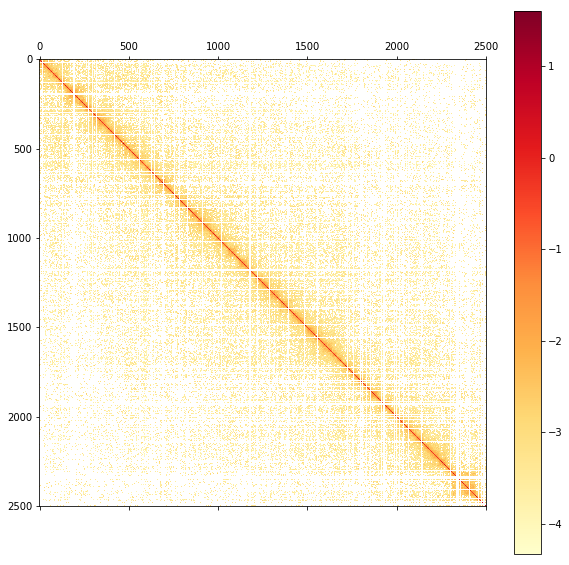

In [219]:
# plots after data cleaning
plot_hic(current_matrix)

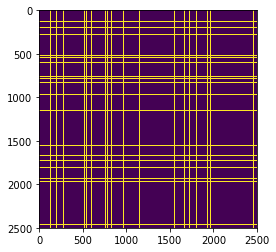

In [220]:
plt.imshow(np.isnan(current_matrix))

In [221]:
resulting_matrices, visualization_matrix = extract_good_regions(current_matrix)

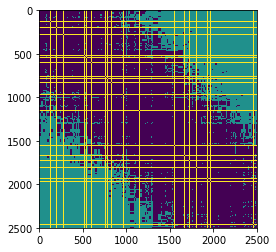

In [222]:
plt.imshow(visualization_matrix)

In [253]:
# DON"T FORGET TO INPUT THESE VALUES
old_min = 0
old_max = 0.12299534722293017

SQUARE_SIZE = 2

Row 0 is predicted
Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted
Row 15 is predicted
Row 16 is predicted
Row 17 is predicted
Row 18 is predicted
Row 19 is predicted
Row 20 is predicted


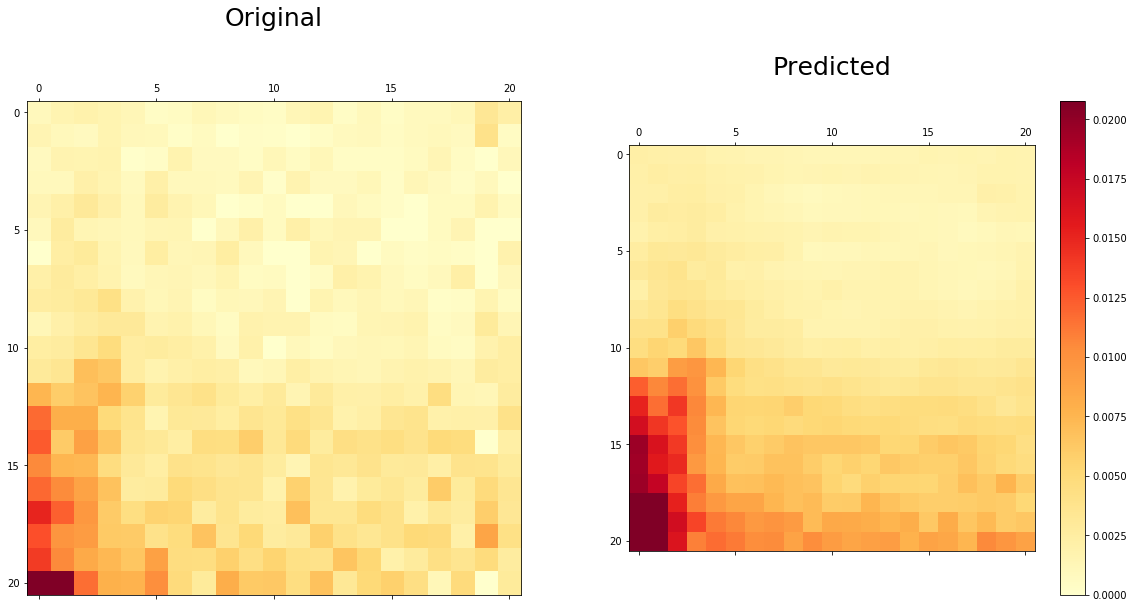

In [258]:
# Predict on dense matrix

normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[77], old_min, old_max)
restored_hic3_deep_keras = restore_hic_v2_keras(normalized_test_matrix, model, SQUARE_SIZE)

plot_two_hic_same_scale(resulting_matrices[77][2:-2, 2:-2], restored_hic3_deep_keras, use_log_scale=False)

Row 0 is predicted
Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted
Row 15 is predicted
Row 16 is predicted
Row 17 is predicted
Row 18 is predicted
Row 19 is predicted
Row 20 is predicted
Row 21 is predicted
Row 22 is predicted
Row 23 is predicted
Row 24 is predicted
Row 25 is predicted
Row 26 is predicted
Row 27 is predicted
Row 28 is predicted
Row 29 is predicted
Row 30 is predicted
Row 31 is predicted
Row 32 is predicted
Row 33 is predicted
Row 34 is predicted
Row 35 is predicted
Row 36 is predicted
Row 37 is predicted
Row 38 is predicted
Row 39 is predicted
Row 40 is predicted
Row 41 is predicted
Row 42 is predicted
Row 43 is predicted
Row 44 is predicted
Row 45 is predicted
Row 46 is predicted
Row 47 is predicted
Row 48 is predicted
Row 49 is predicted
Row 50 is 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


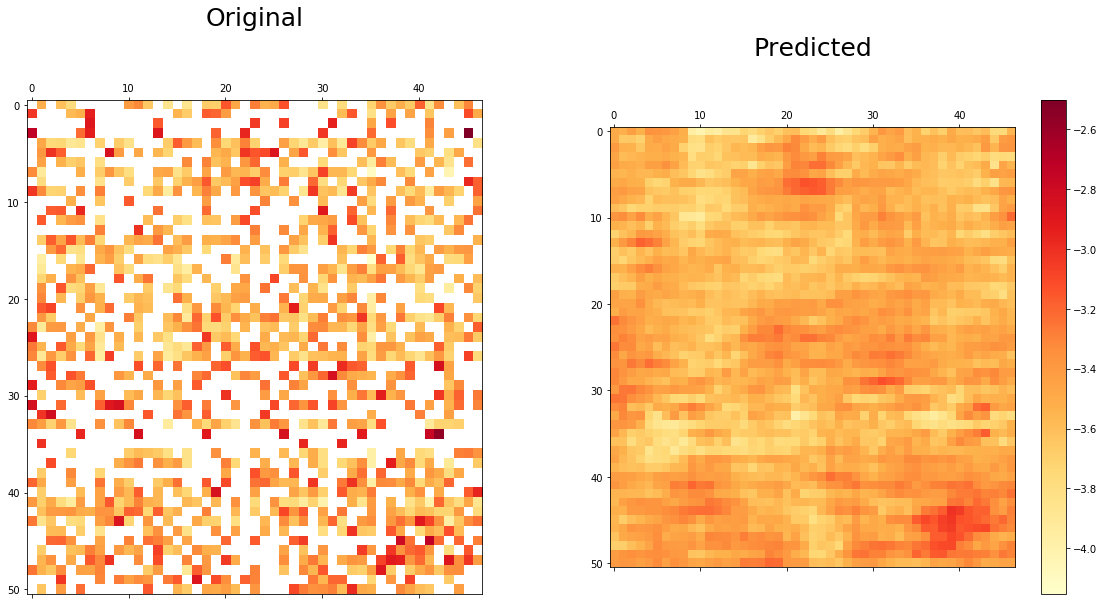

In [256]:
# Predict on sparse matrix

normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[286], old_min, old_max)
restored_hic3_deep_keras = restore_hic_v2_keras(normalized_test_matrix, model, SQUARE_SIZE)

plot_two_hic_same_scale(resulting_matrices[286][2:-2, 2:-2], restored_hic3_deep_keras, use_log_scale=True)

In [361]:
rmse_on_train, r2_on_train = evaluate_model(model, "chr2L")
rmse_on_test, r2_on_test = evaluate_model(model, "chr3R")

In [362]:
print("RMSE on train: " + str(rmse_on_train))
print("RMSE on test: " + str(rmse_on_test))

print("R^2 on train: " + str(r2_on_train))
print("R^2 on test: " + str(r2_on_test))

RMSE on train: 0.0004118287479875277
RMSE on test: 0.0008282923820804351
R^2 on train: 0.8161828131575637
R^2 on test: 0.2540730280992052


In [ ]:
# Keras model V2 (WITH dropout and Batch Normalization)

In [384]:
model = tf.keras.Sequential()

model.add(layers.Dense(120, input_shape=(20,), use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(120, use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(120, use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(120, use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(120, use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(120, use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='mse',
              metrics=['mae'])

In [370]:
history = model.fit(normalized_train_x_v2.T, train_y_v2.T, epochs=3, batch_size=256)

Epoch 1/3
446926/446926 [==============================] - 105s 235us/sample - loss: 0.6754 - mean_absolute_error: 0.4498
Epoch 2/3
446926/446926 [==============================] - 96s 215us/sample - loss: 0.1166 - mean_absolute_error: 0.1892
Epoch 3/3
446926/446926 [==============================] - 108s 242us/sample - loss: 0.0228 - mean_absolute_error: 0.0888


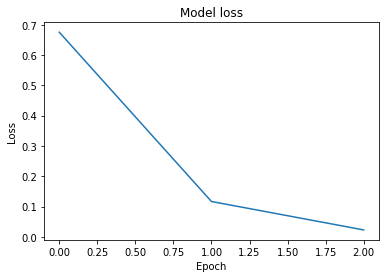

In [371]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Colab specific code - save the model
# model.save_weights('model_v2_normalized_deep_keras.h5', save_format='h5')

In [385]:
model.load_weights('model_v2_normalized_deep_keras.h5')

In [381]:
rmse_on_train, r2_on_train = evaluate_model(model, "chr2L")
rmse_on_test, r2_on_test = evaluate_model(model, "chr3R")

In [382]:
print("RMSE on train: " + str(rmse_on_train))
print("RMSE on test: " + str(rmse_on_test))

print("R^2 on train: " + str(r2_on_train))
print("R^2 on test: " + str(r2_on_test))

RMSE on train: 0.0006270400586025646
RMSE on test: 0.0004586867624290256
R^2 on train: 0.5738687640940875
R^2 on test: 0.7712498485795751


Row 0 is predicted
Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted
Row 15 is predicted
Row 16 is predicted
Row 17 is predicted
Row 18 is predicted
Row 19 is predicted


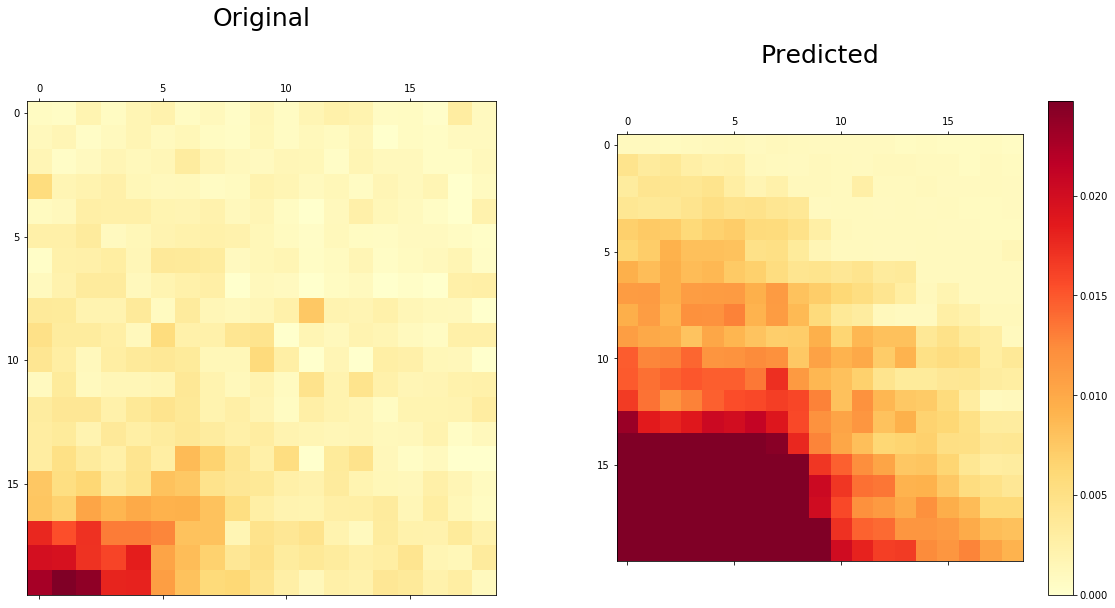

In [388]:
normalized_test_matrix, _, _ = min_max_normalize(resulting_matrices[57], old_min, old_max)
restored_hic3_deep_keras = restore_hic_v2_keras(normalized_test_matrix, model, SQUARE_SIZE)

plot_two_hic_same_scale(resulting_matrices[57][2:-2, 2:-2], restored_hic3_deep_keras, use_log_scale=False)

In [ ]:
# Возможно не хватает тренировочных эпох (несмотря на то, что loss не сильно уменьшается)
# попробовать уменьшить количество эпох на предыдущей сетке и посмотреть, действительно ли надо много тренировать
# возможно нюансы не тренируются при небольшом количестве эпох (очень маленькие числа играют роль?)

In [ ]:
# TODO: try Dropout, Batch normalization +, L2 regularization, 
# additional feature (distance from the diagonal) and see
# if this helps performance on the same / different chromosome
# + also add "interpolation" and write why bicubic interpolation is not relevant in this case
# + also write about why it's not possible to use conv networks in this case